In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
words = stopwords.words("english")
stemmer = SnowballStemmer('english')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brucedecker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brucedecker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
stopwords_set = set(stopwords.words("english"))
df = pd.read_csv('1429_1.csv', keep_default_na=False, skip_blank_lines=False)
df = df.replace(np.nan, '', regex=True)



In [3]:
df['newComments'] = df[['reviews.text', 'reviews.title']].apply(lambda x: ' '.join(x), axis=1)
df['newComments'] = df['reviews.text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in stopwords_set]).lower())
TVec = TfidfVectorizer(sublinear_tf=True, min_df=6, stop_words='english')
ch2 = SelectPercentile(chi2, percentile=9.5)
X_text_processing = TVec.fit_transform(df['newComments'])

#df['reviews.rating'].astype(str).astype(int).astype(float)
#df['reviews.rating'].convert_objects(convert_numeric=True)
df['reviews.rating'] = pd.to_numeric(df['reviews.rating'],errors='coerce')

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df[['reviews.rating']])
df['reviews.rating']=imp.transform(df[['reviews.rating']]).ravel()
'''
imputed_DF = pd.DataFrame(imp.fit_transform(df.loc[:, 14]))
imputed_DF.columns = df.columns
imputed_DF.index = df.index
'''
y_text_processing = df['reviews.rating'].astype(np.int64)

In [4]:
df['newComments']

0        this product far disappoint my children love u...
1           great beginn experienc person bought gift love
2        inexpens tablet use learn step nabi he thrill ...
3        i fire hd two week i love this tablet great va...
4        i bought grand daughter come visit i set user ...
5        this amazon fire inch tablet perfect size i pu...
6        great e read go nice light weight price point ...
7        i gave christma gift inlaw husband uncl they l...
8        great devic read book i like link borrow libra...
9                            i love order book read reader
10                         not easi elder user ceas ad pop
11       excel product easi use larg screen make watch ...
12       want father first tablet good valu he watch mo...
13       simpli everyth i need thank youand silk work w...
14                            got present love size screen
15       the kindl easiest use graphic screen crisp cle...
16       nice reader almost perfect want need good barga

In [5]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col


In [6]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
#spark= SparkSession.builder.getOrCreate()
spark = SparkSession \
  .builder \
  .appName("Python Spark SQL basic example") \
  .config("spark.memory.fraction", 0.80) \
  .config("spark.executor.memory", "4g") \
  .config("spark.driver.memory", "4g")\
  .config("spark.sql.shuffle.partitions" , "900") \
  .getOrCreate()

In [7]:
data = spark.createDataFrame(df)
data = data.select('id', '`reviews.rating`', 'name', 'newComments', "`reviews.doRecommend`")
data.show(5)
print((data.count(), len(data.columns)))



data.groupBy("`reviews.rating`") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

data.groupBy("`reviews.doRecommend`") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------------------+--------------+--------------------+--------------------+-------------------+
|                  id|reviews.rating|                name|         newComments|reviews.doRecommend|
+--------------------+--------------+--------------------+--------------------+-------------------+
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|this product far ...|               TRUE|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|great beginn expe...|               TRUE|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|inexpens tablet u...|               TRUE|
|AVqkIhwDv8e3D1O-lebb|           4.0|All-New Fire HD 8...|i fire hd two wee...|               TRUE|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|i bought grand da...|               TRUE|
+--------------------+--------------+--------------------+--------------------+-------------------+
only showing top 5 rows

(34661, 5)
+-----------------+-----+
|   reviews.rating|count|
+-----------

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Embedding
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from numpy import array
vect = CountVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, min_df=6,  max_features=5000)
label_encoder_y = LabelEncoder()
y_recommended = df['reviews.doRecommend']


#df['reviews.doRecommend'].eq('TRUE').mul(1)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 1 if x == "TRUE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == "FALSE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].replace(np.nan, '', regex=True)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == '' else x)

#print(onehot_encoded)
y_keras = df['reviews.doRecommend']


X_train_kera, X_test_kera, y_train_kera, y_test_kera = train_test_split(df['newComments'], y_keras, test_size=0.2)
X_train_onehot = vect.fit_transform(X_train_kera)


model = Sequential()
model.add(Dense(units=600, activation='linear', input_dim=len(vect.get_feature_names())))
model.add(Dense(units=600, activation='linear', input_dim=len(vect.get_feature_names())))
model.add(Dense(units=600, activation='tanh', input_dim=len(vect.get_feature_names())))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

graph_kera = model.fit(X_train_onehot[:-120], y_train_kera[:-120], 
          epochs=7, batch_size=148, verbose=1, 
          validation_data=(X_train_onehot[-120:], y_train_kera[-120:]))

loss, acc = model.evaluate(vect.transform(X_test_kera), y_test_kera, verbose=1)
print("Accuracy:", acc) 



/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 600)               1485600   
_________________________________________________________________
dense_2 (Dense)              (None, 600)               360600    
_________________________________________________________________
dense_3 (Dense)              (None, 600)               360600    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 601       
Total params: 2,207,401
Trainable params: 2,207,401
Non-trainable params: 0
_________________________________________________________________
Train on 27608 samples, validate on 120 samples
Epoch 1/7
27608/27608 [==============================] - 8s 286us/step - loss: 0.1738 - acc: 0.9429 - val_loss: 0.2081 - val_acc: 0.9250
Epoch 2/7
27608/27608 [==============================] - 7s 272us/step - loss: 

In [9]:
#model.add(Dense(units=600, activation='linear', input_dim=1392)
y_pred_keras = model.predict(vect.transform(X_test_kera))

In [10]:
y_pred_keras2 = []
for item in y_pred_keras:
    if item >= 0.5:
        y_pred_keras2.append(1)
    else:
        y_pred_keras2.append(0)

In [11]:
y_test_kera.size

6933

In [12]:
y_test_keras2 = []
for item in y_test_kera:
    y_test_keras2.append(item)
y_test_kera = y_test_keras2

Current size: [6.0, 4.0]


Text(0.5,1,'Deep Neutral Network Classification')

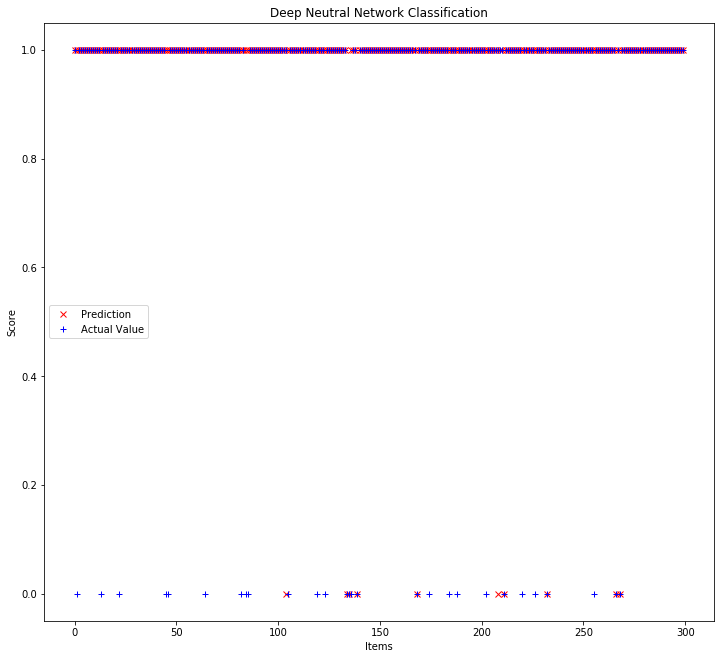

In [13]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_keras2[:300], 'xr', label='Prediction')
plt.plot(y_test_kera[:300], '+b', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Deep Neutral Network Classification")

In [14]:
from sklearn.metrics import f1_score
DNN_f1 = f1_score(y_test_kera, y_pred_keras2)

In [15]:
DNN_f1

0.9734765947854835

In [16]:
acc = graph_kera.history['acc']
val_acc = graph_kera.history['val_acc']
loss = graph_kera.history['loss']
val_loss = graph_kera.history['val_loss']

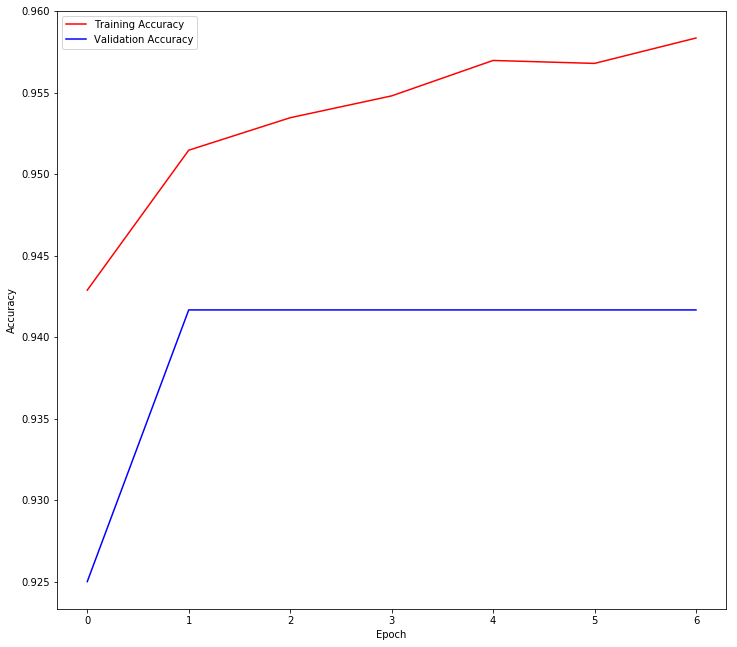

In [17]:
plt.plot(acc, 'r', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
#plt.plot(loss, 'b', label='Training loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend()


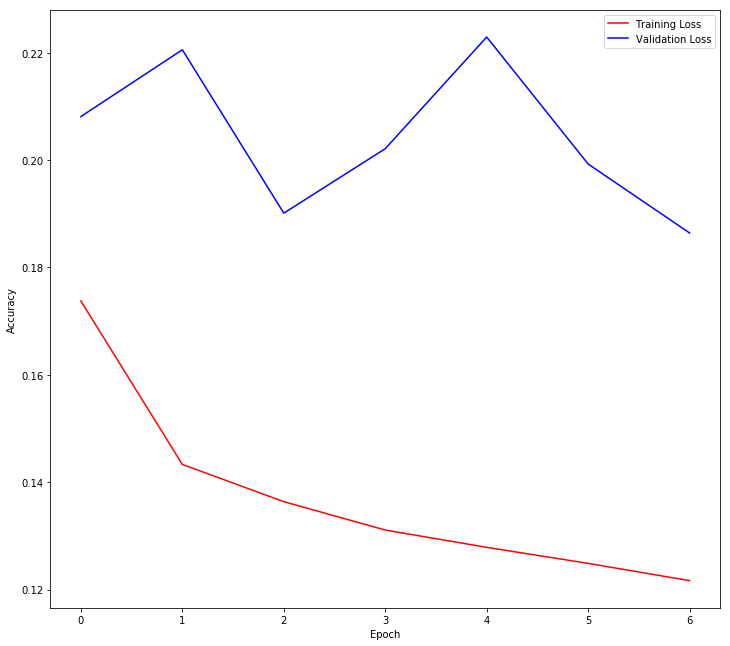

In [18]:
plt.plot(loss, 'r', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
#plt.plot(loss, 'b', label='Training loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend()



In [19]:
# Recurrent Neural Network
import tensorflow as tf
from tensorflow.python.keras.optimizers import Adam, Adadelta
from tensorflow.python.keras.optimizers import Adagrad
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.preprocessing.text import Tokenizer
from scipy.spatial.distance import cdist
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, Conv1D, Conv2D, GaussianNoise
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from functools import reduce

In [20]:
num_word_len = 9000
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(df['newComments'], y_keras, test_size=0.2)
all_words_tf = df['newComments'].tolist()
token = Tokenizer(num_words=num_word_len)
token.fit_on_texts(all_words_tf)

In [21]:
X_train_tf = token.texts_to_sequences(X_train_tf)
X_test_tf = token.texts_to_sequences(X_test_tf)

In [22]:
num_item = []
for item in X_train_tf + X_test_tf:
    num_item.append(len(item))
num_item = np.array(num_item)


In [23]:
max_items = int(reduce(lambda x, y: x + y, num_item) / len(num_item) + 2 * np.std(num_item))

In [24]:
max_items

55

In [25]:
X_train_tf = pad_sequences(X_train_tf, maxlen=max_items, padding='pre', truncating='pre')
X_test_tf = pad_sequences(X_test_tf, maxlen=max_items, padding='pre', truncating='pre')

In [26]:
#Embedding Layer 
model = Sequential()
embedding_size = 50
model.add(Embedding(input_dim=num_word_len, output_dim=embedding_size, input_length=max_items, name='layer_embedding'))
model.add(GRU(units=20, return_sequences=True))
model.add(GRU(units=10, return_sequences=True))
model.add(GRU(units=5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 55, 50)            450000    
_________________________________________________________________
gru (GRU)                    (None, 55, 20)            4260      
_________________________________________________________________
gru_1 (GRU)                  (None, 55, 10)            930       
_________________________________________________________________
gru_2 (GRU)                  (None, 5)                 240       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 455,436
Trainable params: 455,436
Non-trainable params: 0
_________________________________________________________________


In [27]:
graph_tf = model.fit(X_train_tf, y_train_tf, validation_split=0.15, epochs= 5, batch_size=64)

/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 23568 samples, validate on 4160 samples
Epoch 1/5
23568/23568 [==============================] - 43s 2ms/step - loss: 0.2416 - acc: 0.9398 - val_loss: 0.2072 - val_acc: 0.9454
Epoch 2/5
23568/23568 [==============================] - 42s 2ms/step - loss: 0.1921 - acc: 0.9469 - val_loss: 0.1804 - val_acc: 0.9454
Epoch 3/5
23568/23568 [==============================] - 42s 2ms/step - loss: 0.1558 - acc: 0.9511 - val_loss: 0.1627 - val_acc: 0.9462
Epoch 4/5
23568/23568 [==============================] - 42s 2ms/step - loss: 0.1273 - acc: 0.9580 - val_loss: 0.1477 - val_acc: 0.9510
Epoch 5/5
23568/23568 [==============================] - 42s 2ms/step - loss: 0.1098 - acc: 0.9649 - val_loss: 0.1785 - val_acc: 0.9284


In [28]:
y_pred_tf = model.predict(X_test_tf)

In [29]:
y_test_tf2 = []
y_pred_tf2 = []
for item in y_test_tf:
    y_test_tf2.append(item)
for item in y_pred_tf:
    if item >= 0.5:
        y_pred_tf2.append(1)
    else:
        y_pred_tf2.append(0)

In [30]:
RNN_f1 = f1_score(y_test_tf2, y_pred_tf2)

In [31]:
RNN_f1

0.9574319609211445

Current size: [12.0, 11.0]


Text(0.5,1,'Recurrent Neutral Network Classification')

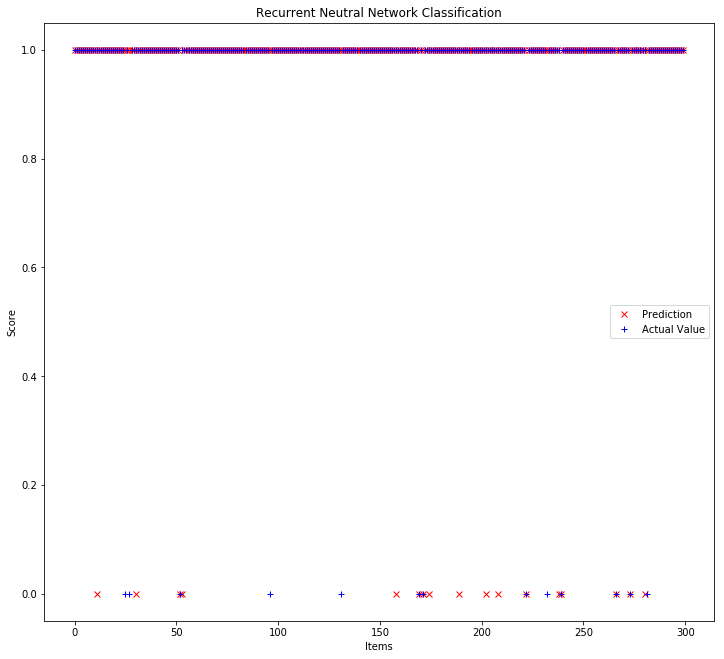

In [32]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_tf2[:300], 'xr', label='Prediction')
plt.plot(y_test_tf2[:300], '+b', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Recurrent Neutral Network Classification")

In [33]:
loss_tf, acc_tf = model.evaluate(X_test_tf, y_test_tf, verbose=1)
print("Accuracy:", acc_tf) 



6933/6933 [==============================] - 6s 859us/step
Accuracy: 0.9208135006662641


In [34]:
acc_tf = graph_tf.history['acc']
val_acc_tf = graph_tf.history['val_acc']
loss_tf = graph_tf.history['loss']
val_loss_tf = graph_tf.history['val_loss']

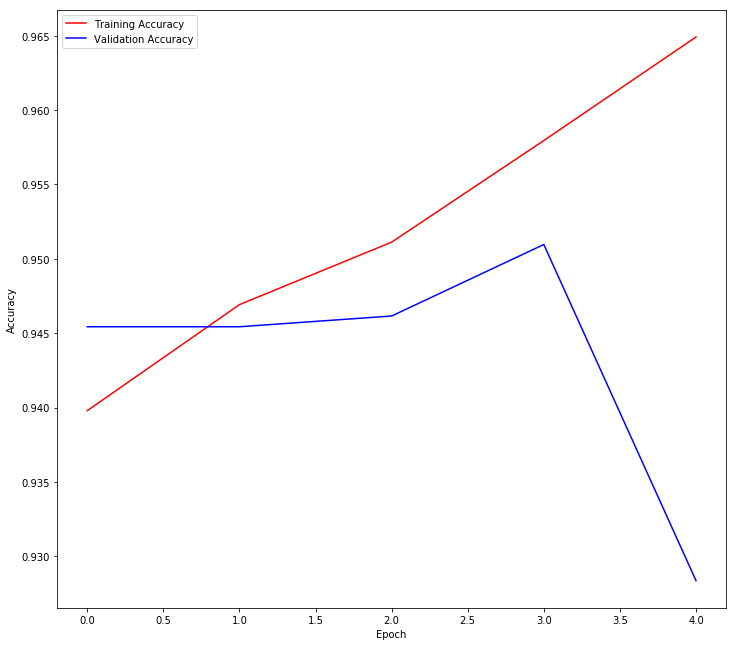

In [35]:
plt.plot(acc_tf, 'r', label='Training Accuracy')
plt.plot(val_acc_tf, 'b', label='Validation Accuracy')
#plt.plot(loss, 'b', label='Training loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend()

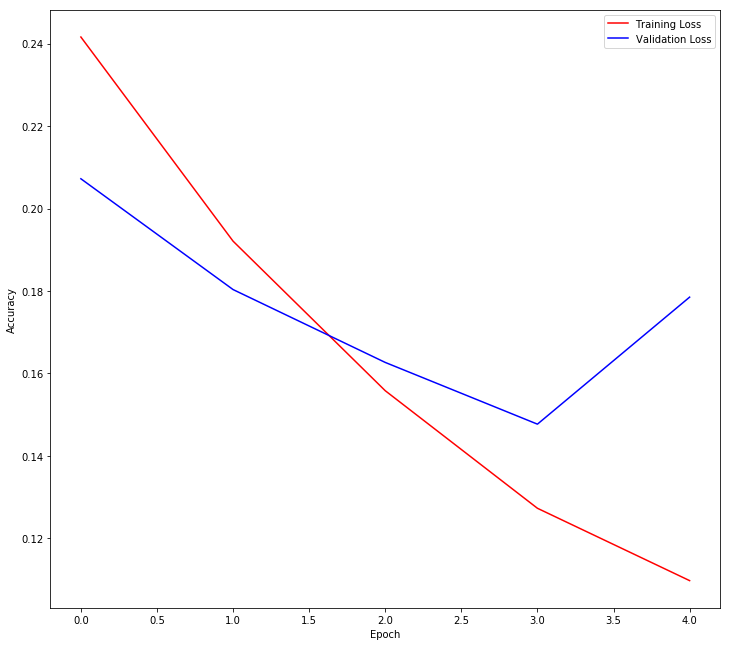

In [36]:
plt.plot(loss_tf, 'r', label='Training Loss')
plt.plot(val_loss_tf, 'b', label='Validation Loss')
#plt.plot(loss, 'b', label='Training loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend()



In [37]:
test1 = "This product from Amazon is very good"
test2 = "I really enjoy it!"
test3 = "Fantastic product!"
test_collection = []
test_collection.extend((test1, test2, test3))

In [38]:
test_collection = token.texts_to_sequences(test_collection)
test_collection = pad_sequences(test_collection, maxlen=max_items, padding='pre', truncating='pre')

In [39]:
model.predict(test_collection)

array([[0.91216   ],
       [0.89733636],
       [0.1568552 ]], dtype=float32)

In [40]:
from sklearn.cross_validation import train_test_split
X_train = vect.transform(X_train_kera)
X_test = vect.transform(X_test_kera)
y_train = y_train_kera
y_test = y_test_kera

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [41]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)

In [42]:
tree_f1_recommend = f1_score(y_pred_tree, y_test, average='weighted')

In [43]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)
y_pred_MultinomialNB = clf.predict(X_test.toarray())

In [44]:
MultinomialNB_f1_recommend = f1_score(y_pred_MultinomialNB, y_test, average='weighted')

In [45]:
MultinomialNB_f1_recommend

0.9385223073237

In [46]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB().fit(X_train.toarray(), y_train)
y_pred_GaussianNB = clf.predict(X_test.toarray())

In [47]:
GaussianNB_f1_recommend = f1_score(y_pred_GaussianNB, y_test, average='weighted')

In [48]:
GaussianNB_f1_recommend

0.12932385738682053

In [49]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)
y_pred_MLP = clf.predict(X_test)

In [50]:
MLP_f1_recommend = f1_score(y_pred_MLP , y_test, average='weighted')

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [51]:
MLP_f1_recommend

0.9711360094976627

In [52]:
from sklearn.ensemble import RandomForestClassifier


In [53]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0).fit(X_train, y_train)
y_pred_RandomForest = clf.predict(X_test)

In [54]:
RandomForest_f1_recommend = f1_score(y_pred_RandomForest, y_test, average='weighted')

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [55]:
RandomForest_f1_recommend

0.9711360094976627

In [56]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=700)
neigh.fit(X_train, y_train) 
y_pred_KNeighbors = neigh.predict(X_test)

In [57]:
KNeighbors_f1_recommend = f1_score(y_pred_KNeighbors, y_test, average='weighted')

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [58]:
KNeighbors_f1_recommend

0.9711360094976627

In [59]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5).fit(X_train, y_train)
y_pred_LinearSVC = clf.predict(X_test)

In [60]:
LinearSVC_f1_recommend = f1_score(y_pred_LinearSVC, y_test, average='weighted')

In [61]:
LinearSVC_f1_recommend

0.9495387450711864

"\nfrom matplotlib.pyplot import figure\n\nobjects = ('Decision Tree', 'Gaussian', 'Multinomial', 'Multi-layer Perceptron', 'Random Forest', 'K-Nearest Neighbor', 'Linear SVC', 'DNN', 'RNN')\ny_pos = np.arange(len(objects))\nperformance = [tree_f1_recommend, GaussianNB_f1_recommend, MultinomialNB_f1_recommend, MLP_f1_recommend, RandomForest_f1_recommend, KNeighbors_f1_recommend, LinearSVC_f1_recommend, DNN_f1, RNN_f1]\nfigure(num=None, figsize=(19, 12), dpi=80, facecolor='w', edgecolor='k')\nplt.bar(y_pos, performance, align='center', alpha=0.9)\nplt.xticks(y_pos, objects)\nplt.ylabel('f1')\nplt.title('Comparision of Deep Learning vs. Machine Learning on f1 score')\n \nplt.show()\nfor i, v in enumerate(y):\n    plt.text(v, i, str(v), color='blue', fontweight='bold')\n"

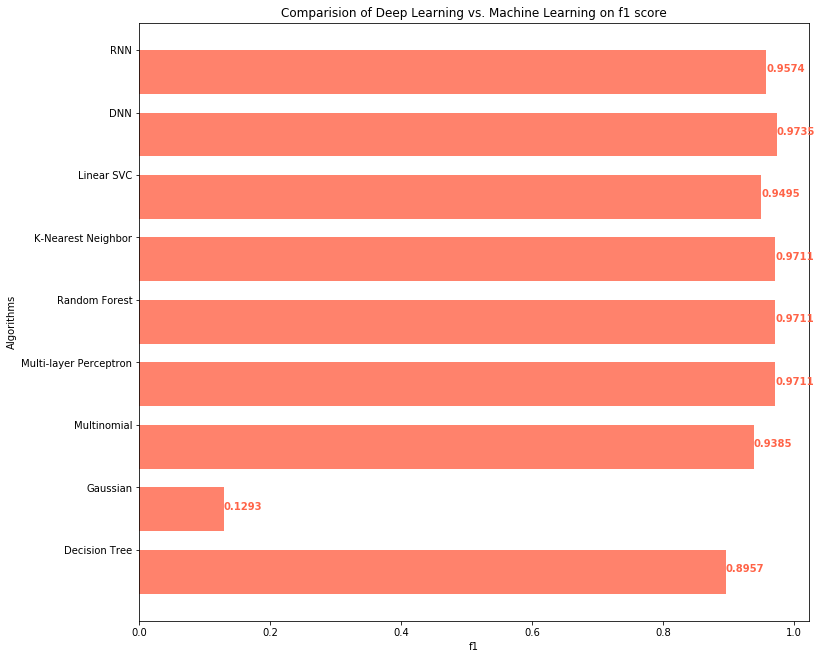

In [63]:
objects = ('Decision Tree', 'Gaussian', 'Multinomial', 'Multi-layer Perceptron', 'Random Forest', 'K-Nearest Neighbor', 'Linear SVC', 'DNN', 'RNN')
performance = [tree_f1_recommend, GaussianNB_f1_recommend, MultinomialNB_f1_recommend, MLP_f1_recommend, RandomForest_f1_recommend, KNeighbors_f1_recommend, LinearSVC_f1_recommend, DNN_f1, RNN_f1]
performance2 = []
for item in performance:
    round_num = round(item, 4)
    performance2.append(round_num )
performance = performance2
fig, ax = plt.subplots()    
width = 0.7 
ind = np.arange(len(performance))  
ax.barh(ind, performance, width, color="tomato", alpha=0.8)
ax.set_yticks(ind+width/2)
ax.set_yticklabels(objects, minor=False)
plt.title('Comparision of Deep Learning vs. Machine Learning on f1 score')
plt.xlabel('f1')
plt.ylabel('Algorithms')      



for key, value in enumerate(performance):
    ax.text(value, key, str(value), color='tomato', fontweight='bold')

'''
from matplotlib.pyplot import figure

objects = ('Decision Tree', 'Gaussian', 'Multinomial', 'Multi-layer Perceptron', 'Random Forest', 'K-Nearest Neighbor', 'Linear SVC', 'DNN', 'RNN')
y_pos = np.arange(len(objects))
performance = [tree_f1_recommend, GaussianNB_f1_recommend, MultinomialNB_f1_recommend, MLP_f1_recommend, RandomForest_f1_recommend, KNeighbors_f1_recommend, LinearSVC_f1_recommend, DNN_f1, RNN_f1]
figure(num=None, figsize=(19, 12), dpi=80, facecolor='w', edgecolor='k')
plt.bar(y_pos, performance, align='center', alpha=0.9)
plt.xticks(y_pos, objects)
plt.ylabel('f1')
plt.title('Comparision of Deep Learning vs. Machine Learning on f1 score')
 
plt.show()
for i, v in enumerate(y):
    plt.text(v, i, str(v), color='blue', fontweight='bold')
'''



In [269]:
all_words = []
for index in range(df['newComments'].size):
    all_words.append(df['newComments'][index])


In [270]:
all_words[0]

'this product far disappoint my children love use i like abil monitor control content see eas'

In [271]:
X_process = TVec.fit_transform(all_words).toarray()

In [272]:
df['newComments'][df['newComments'] == ''].index

Int64Index([3111, 9705, 34660], dtype='int64')

In [273]:
df['newComments'].isna().any()

False

In [274]:
df['reviews.rating'].isna().any()

False

In [275]:
y_rating = df['reviews.rating'].astype(np.int64)

In [276]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_process, y_rating, test_size = 0.25, random_state = 0)

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
tree_rms = sqrt(mean_squared_error(y_pred_tree, y_test))



In [277]:
tree_rms

0.8530365521683895

In [278]:
y_pred_tree = y_pred_tree.tolist()

In [279]:

from sklearn.metrics import f1_score
tree_f1 = f1_score(y_pred_tree, y_test, average='weighted')
print(f1_score(y_pred_tree, y_test, average='weighted'))

0.6295238521690761


In [280]:
y_test = y_test.tolist()

Current size: [12.0, 11.0]


Text(0.5,1,'Decision Tree NLP')

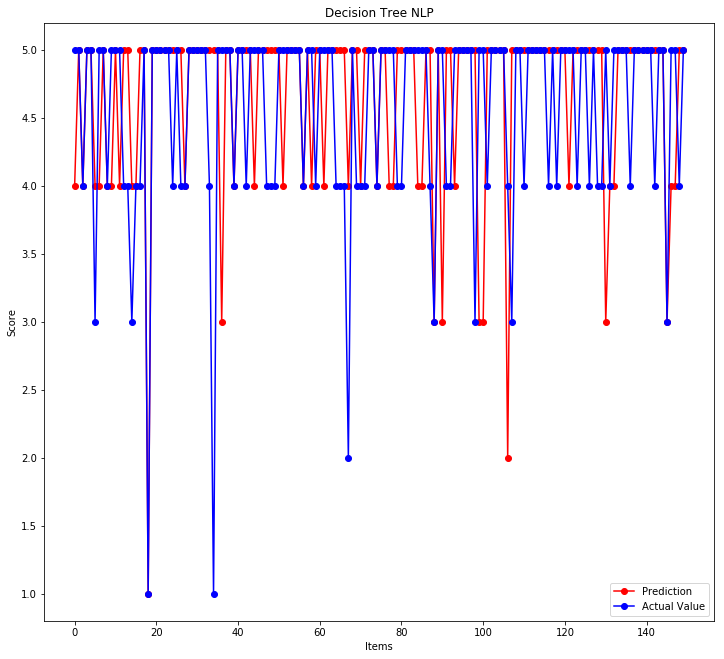

In [281]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_tree[:150], '-or', label='Prediction')
plt.plot(y_test[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Decision Tree NLP")

In [282]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB().fit(X_train, y_train)
y_pred_naive_bayes = clf.predict(X_test)

In [283]:
naive_bayesGaussianNBrms = sqrt(mean_squared_error(y_pred_naive_bayes, y_test))

In [284]:
naive_bayesGaussianNBrms


2.604873913501163

Current size: [12.0, 11.0]


Text(0.5,1,'Gaussian Naive Bayes NLP')

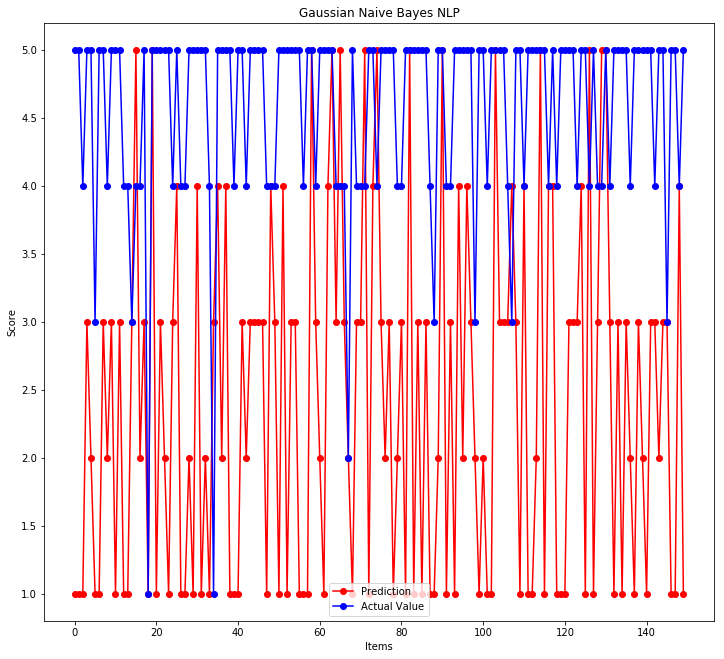

In [285]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_naive_bayes[:150], '-or', label='Prediction')
plt.plot(y_test[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Gaussian Naive Bayes NLP")

In [286]:
naive_bayesGaussianNBf1 = f1_score(y_pred_naive_bayes, y_test, average='weighted')
print(f1_score(y_pred_naive_bayes, y_test, average='weighted'))

0.07762397135740418


In [287]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)
y_pred_MultinomialNB = clf.predict(X_test)

In [288]:
naive_bayes_rms = sqrt(mean_squared_error(y_pred_MultinomialNB, y_test))
naive_bayes_rms 

0.7755941417972513

Current size: [12.0, 11.0]


Text(0.5,1,'Naive Bayes Sentiment Analysis')

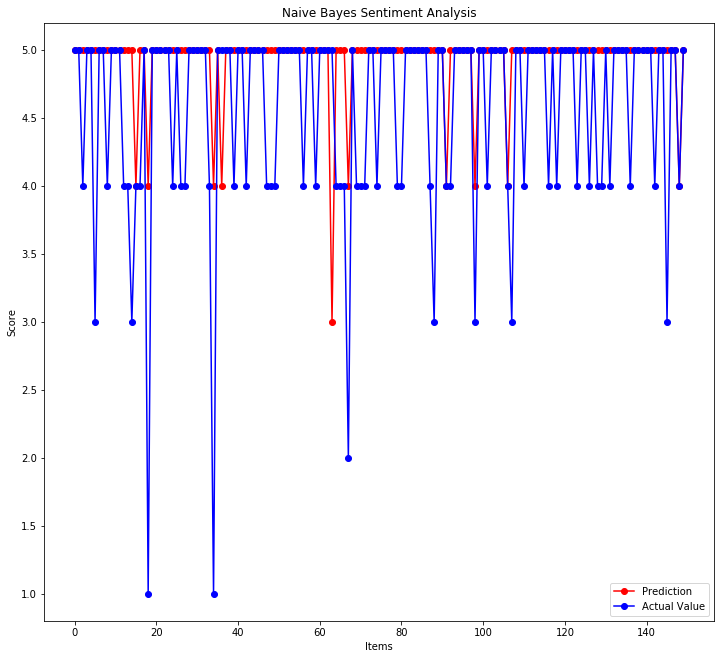

In [289]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_MultinomialNB[:150], '-or', label='Prediction')
plt.plot(y_test[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Naive Bayes Sentiment Analysis")


In [290]:
naive_bayes_f1 = f1_score(y_pred_MultinomialNB, y_test, average='weighted')
print(f1_score(y_pred_MultinomialNB, y_test, average='weighted'))

0.7902955447986636


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [291]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)
y_pred_MLP = clf.predict(X_test)


In [292]:
MLP_rms = sqrt(mean_squared_error(y_pred_MLP, y_test))
MLP_rms 

0.6879162084881861

Current size: [12.0, 11.0]


Text(0.5,1,'Multi-layer Perceptron Sentiment Analysis')

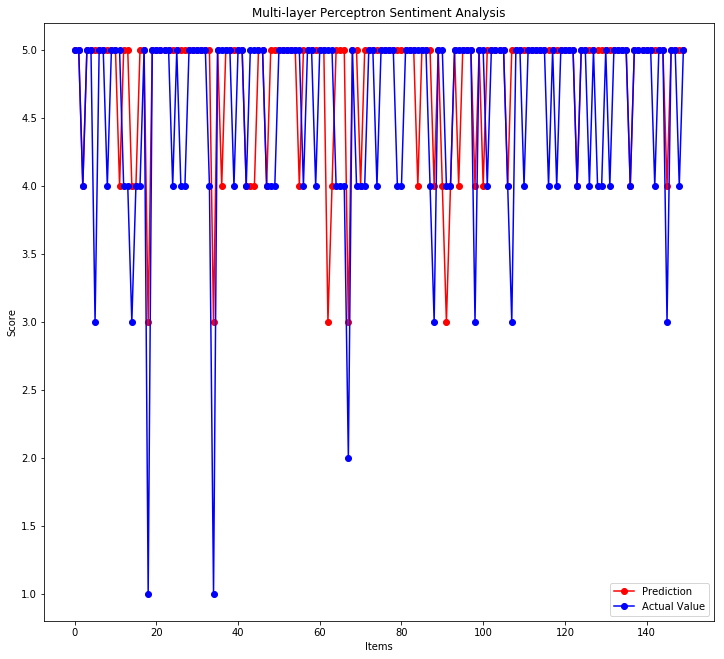

In [293]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_MLP[:150], '-or', label='Prediction')
plt.plot(y_test[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Multi-layer Perceptron Sentiment Analysis")



In [294]:
MLP_f1 = f1_score(y_pred_MLP, y_test, average='weighted')
print(f1_score(y_pred_MLP, y_test, average='weighted'))

0.7120187554128428


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


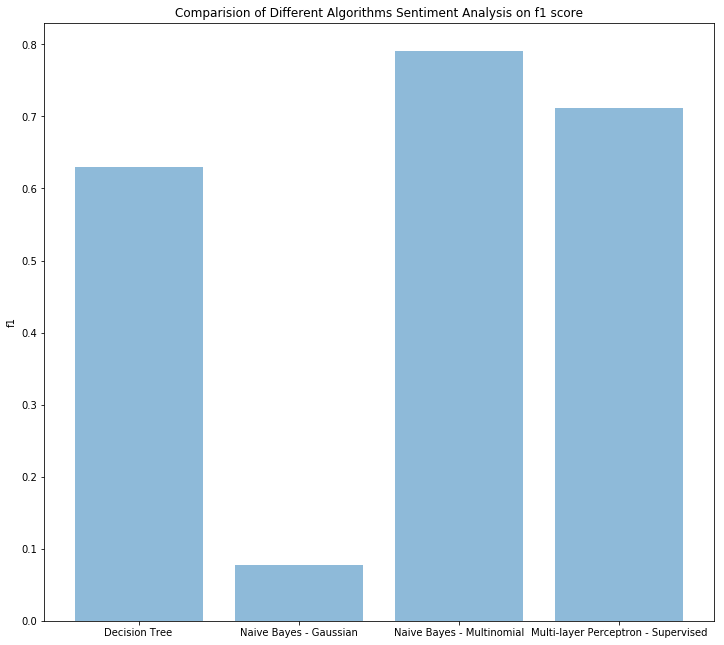

In [295]:
objects = ('Decision Tree', 'Naive Bayes - Gaussian', 'Naive Bayes - Multinomial', 'Multi-layer Perceptron - Supervised')
y_pos = np.arange(len(objects))
performance = [tree_f1, naive_bayesGaussianNBf1, naive_bayes_f1, MLP_f1]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('f1')
plt.title('Comparision of Different Algorithms Sentiment Analysis on f1 score')
 
plt.show()

In [62]:
pd.options.display.max_columns = None
display(df)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,newComments
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,,,Adapter,this product far disappoint my children love u...
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,,,truman,great beginn experienc person bought gift love
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,,,DaveZ,inexpens tablet use learn step nabi he thrill ...
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,4.000000,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,,,Shacks,i fire hd two week i love this tablet great va...
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,,,explore42,i bought grand daughter come visit i set user ...
5,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,This amazon fire 8 inch tablet is the perfect ...,Just what we expected,,,tklit,this amazon fire inch tablet perfect size i pu...
6,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,4.000000,http://reviews.bestbuy.com/3545/5620406/review...,"Great for e-reading on the go, nice and light ...",great e-reader tablet,,,Droi,great e read go nice light weight price point ...
7,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-0

In [63]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [64]:

def generate_word_cloud(data, color = 'black'):
    
    words = ' '.join(data)
    processed_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=3000,
                      height=2500
                     ).generate(processed_word)
    plt.figure(1,figsize=(15, 14))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()


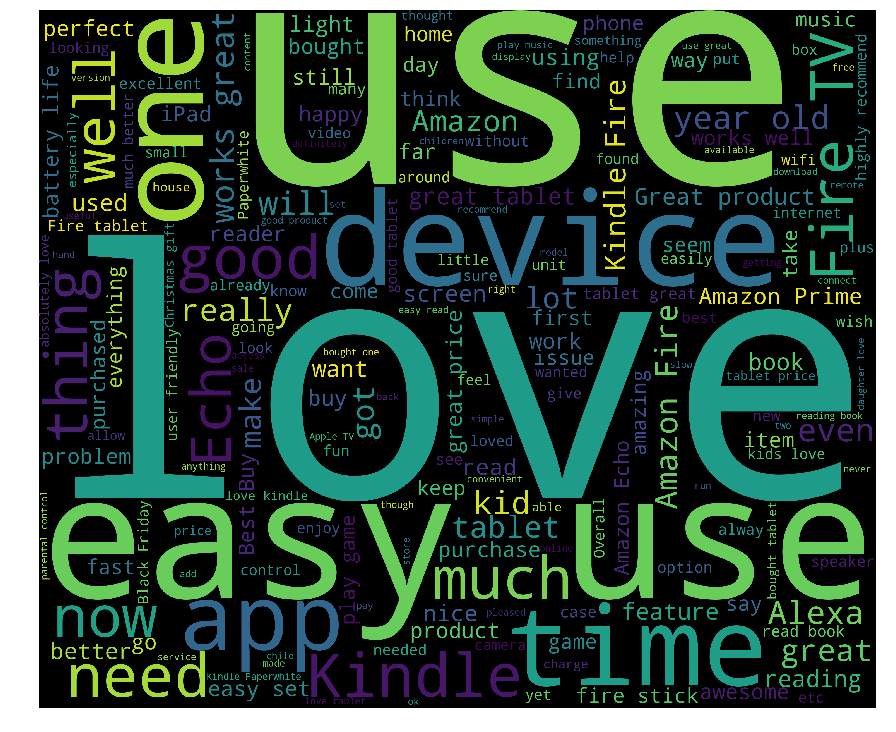

In [65]:
generate_word_cloud(df["reviews.text"],'black')


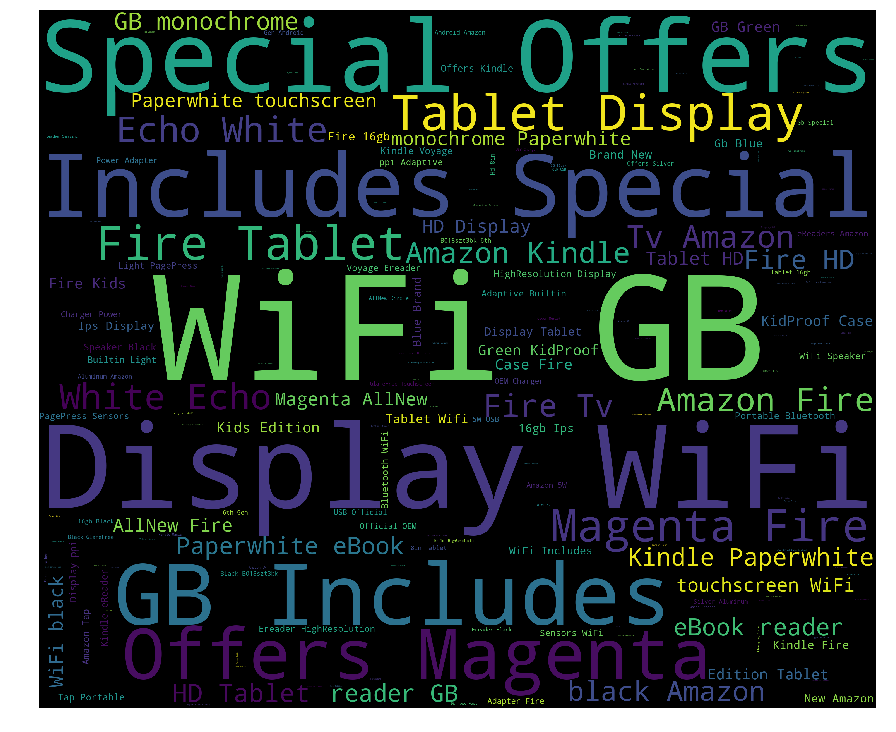

In [66]:
df['name'] = df['name'].replace(',', ' ', regex=True)
df['name'] = df['name'].replace('-', '', regex=True)
generate_word_cloud( df['name'],'black')

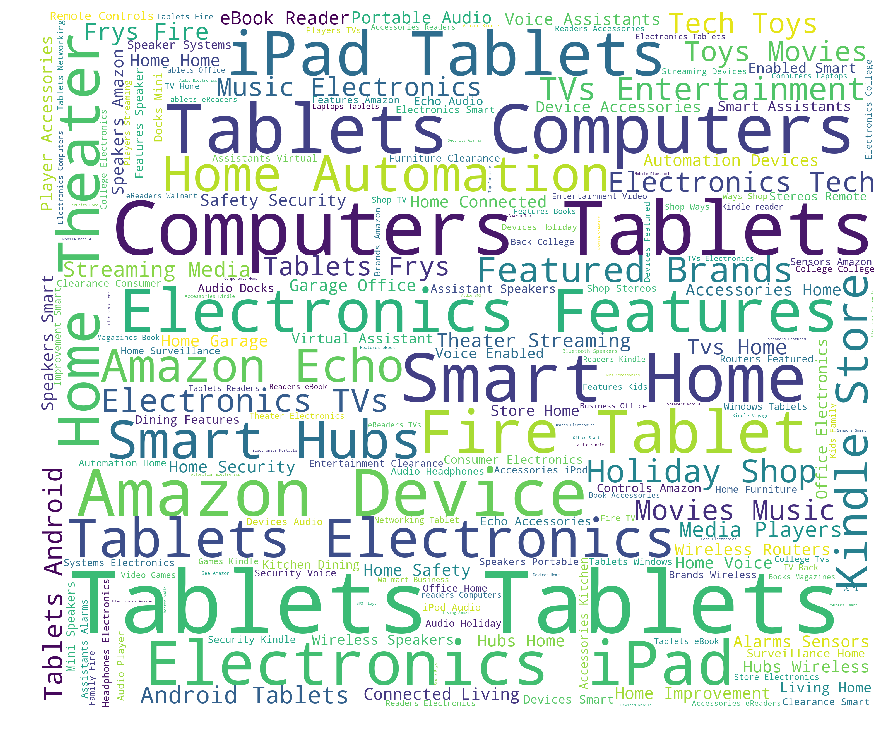

In [67]:
generate_word_cloud( df['categories'],'white')

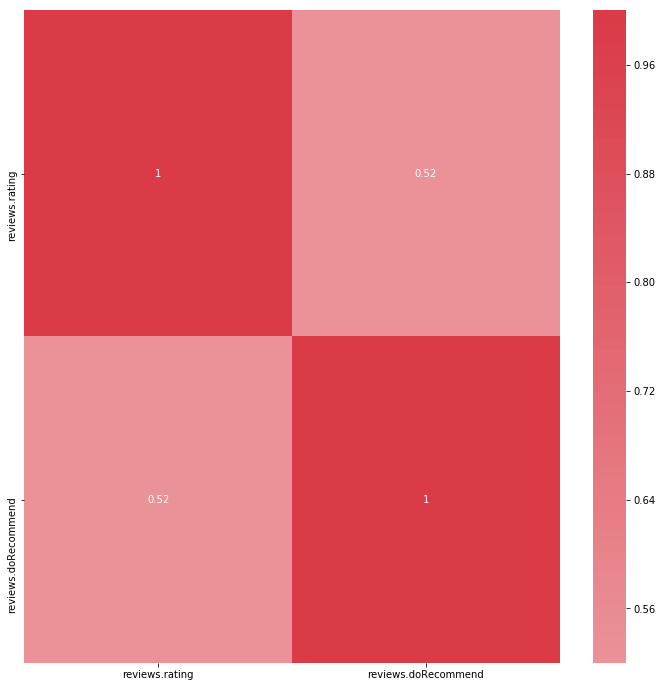

In [68]:
import seaborn as sns

numeric_features = ['reviews.rating']
ordinal_features = ['reviews.doRecommend', 'brand', 'name']
nominal_features = ['name', 'categories', 'brand']
cor_matrix = df[numeric_features + ordinal_features + nominal_features].corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(12,12));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

In [69]:
from sklearn_pandas import CategoricalImputer
imputerCategorical = CategoricalImputer()
df.replace(' ', np.nan, inplace=True)
df['brand'] = imputerCategorical.fit_transform(df['brand'])

In [70]:
brand_type = df.groupby("brand")
brand_type.describe().head(5)

reviews.doRecommend                           \
                                           count      mean       std  min   
brand                                                                       
                                             1.0  0.000000       NaN  0.0   
Amazon                                   28701.0  0.938957  0.239414  0.0   
Amazon Coco T                                1.0  0.000000       NaN  0.0   
Amazon Digital Services Inc.                10.0  0.000000  0.000000  0.0   
Amazon Echo                                636.0  0.926101  0.261813  0.0   

                                                 reviews.rating            \
                              25%  50%  75%  max          count      mean   
brand                                                                       
                              0.0  0.0  0.0  0.0            1.0  4.584573   
Amazon                        1.0  1.0  1.0  1.0        28701.0  4.564744   
Amazon Coco T                 0.0  0.0  0.0  0.0            1.0  4.584573   
Amazon Digital Services Inc.  0.0  0.0  0.0  0.0           10.0  3.500000   
Amazon Echo                   1.0  1.0  1.0  1.0          636.0  4.531447   

                                                                      \
                                   std       min       25%       50%   
brand                                                                  
                                   NaN  4.584573  4.584573  4.584573   
Amazon                        0.746727  1.000000  4.000000  5.000000   
Amazon Coco T                      NaN  4.584573  4.584573  4.584573   
Amazon Digital Services Inc.  1.840894  1.000000  1.500000  4.500000   
Amazon Echo                   0.819421  1.000000  4.000000  5.000000   

                                                  
                                   75%       max  
brand                                             
                              4.584573  4.584573  
Amazon                        5.000000  5.000000  
Amazon Coco T                 4.584573  4.584573  
Amazon Digital Services Inc.  5.000000  5.000000  
Amazon Echo                   5.000000  5.000000

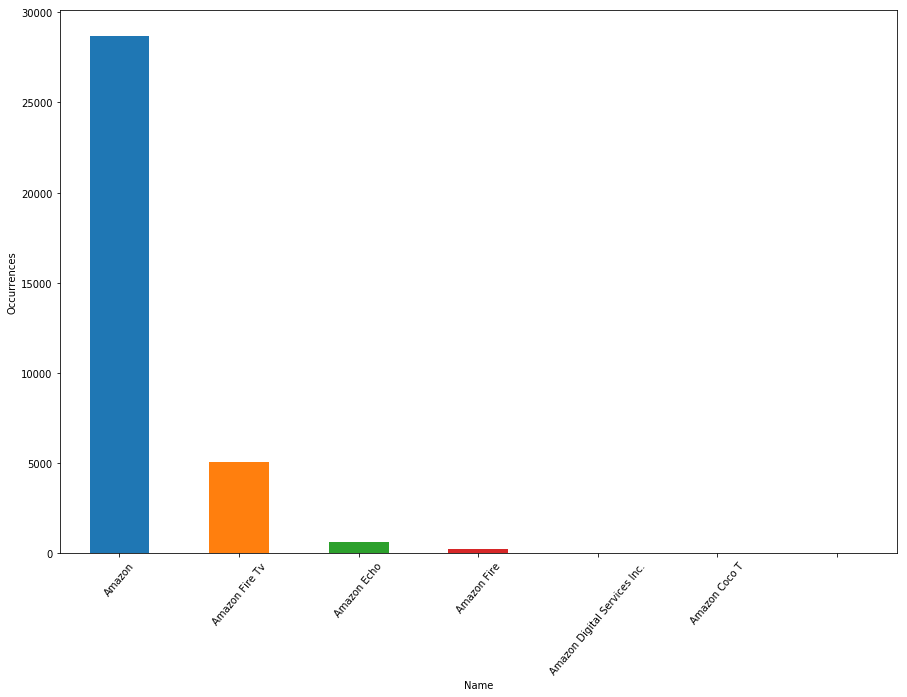

In [71]:
plt.figure(figsize=(15,10))
brand_type.size().sort_values(ascending=False).plot.bar()
#df['categories'].value_counts().head(10).plot('bar')
plt.xticks(rotation=50)
plt.xlabel("Name")
plt.ylabel("Occurrences")
plt.show()

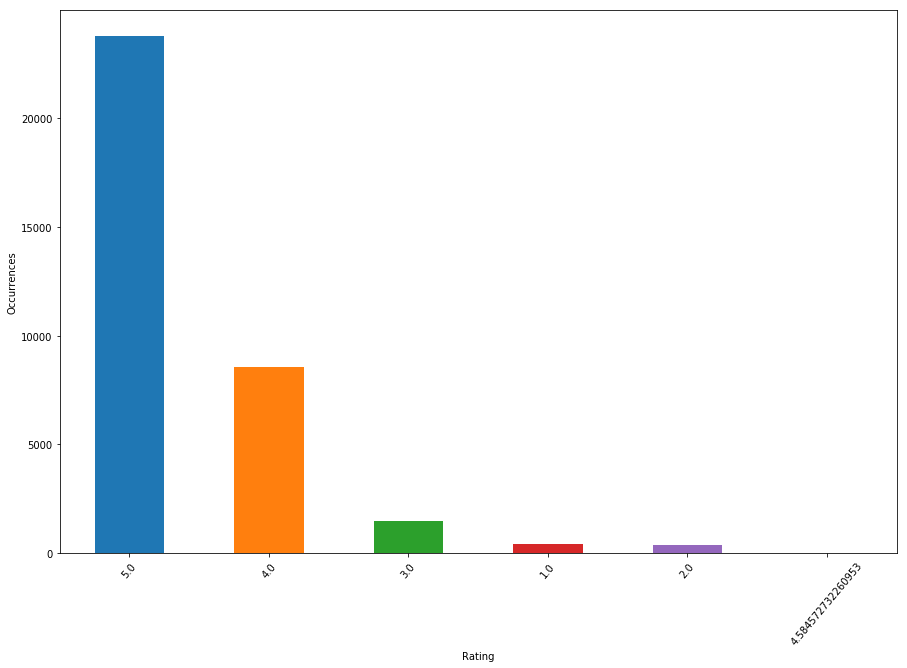

In [72]:
rating_type = df.groupby("reviews.rating")
rating_type.describe().head(5)
plt.figure(figsize=(15,10))
rating_type.size().sort_values(ascending=False).plot.bar()
#df['categories'].value_counts().head(10).plot('bar')
plt.xticks(rotation=50)
plt.xlabel("Rating")
plt.ylabel("Occurrences")
plt.show()

In [73]:
df['reviews.doRecommend']

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
34631    0
34632    0
34633    0
34634    0
34635    0
34636    0
34637    0
34638    0
34639    0
34640    0
34641    0
34642    0
34643    0
34644    0
34645    0
34646    0
34647    0
34648    0
34649    0
34650    0
34651    0
34652    0
34653    0
34654    0
34655    0
34656    0
34657    0
34658    0
34659    0
34660    0
Name: reviews.doRecommend, Length: 34661, dtype: int64

In [74]:
data = spark.createDataFrame(df)

In [75]:
data = data.select('id', '`reviews.rating`', 'name', 'newComments', "`reviews.doRecommend`")
data.printSchema()
data.show(5)

root
 |-- id: string (nullable = true)
 |-- reviews.rating: double (nullable = true)
 |-- name: string (nullable = true)
 |-- newComments: string (nullable = true)
 |-- reviews.doRecommend: long (nullable = true)

+--------------------+--------------+--------------------+--------------------+-------------------+
|                  id|reviews.rating|                name|         newComments|reviews.doRecommend|
+--------------------+--------------+--------------------+--------------------+-------------------+
|AVqkIhwDv8e3D1O-lebb|           5.0|AllNew Fire HD 8 ...|this product far ...|                  1|
|AVqkIhwDv8e3D1O-lebb|           5.0|AllNew Fire HD 8 ...|great beginn expe...|                  1|
|AVqkIhwDv8e3D1O-lebb|           5.0|AllNew Fire HD 8 ...|inexpens tablet u...|                  1|
|AVqkIhwDv8e3D1O-lebb|           4.0|AllNew Fire HD 8 ...|i fire hd two wee...|                  1|
|AVqkIhwDv8e3D1O-lebb|           5.0|AllNew Fire HD 8 ...|i bought grand da...|       

In [76]:
data.groupBy("`reviews.doRecommend`") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()
    

+-------------------+-----+
|reviews.doRecommend|count|
+-------------------+-----+
|                  1|32682|
|                  0| 1979|
+-------------------+-----+



In [77]:
label_encoder = LabelEncoder()

In [78]:
product_name = df['name']

In [79]:
data.groupBy("name") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()
    

+--------------------+-----+
|                name|count|
+--------------------+-----+
|Fire Tablet  7 Di...|10966|
|                    | 6760|
|Echo (White)   
...| 3309|
|Amazon Kindle Pap...| 3176|
|AllNew Fire HD 8 ...| 2814|
|Amazon Fire Tv   ...| 2527|
|Fire Kids Edition...| 1685|
|Brand New Amazon ...| 1038|
|Kindle Voyage Ere...|  580|
|Fire Tablet  7 Di...|  372|
|Amazon  Amazon Ta...|  318|
|AllNew Kindle Ere...|  212|
|Amazon 5W USB Off...|  208|
|AllNew Fire HD 8 ...|  158|
|Amazon Fire Hd 8 ...|  135|
|Amazon Fire Hd 10...|  128|
|Kindle Oasis Erea...|   67|
|Amazon 9W PowerFa...|   36|
|Kindle Paperwhite...|   30|
|Amazon  Kindle Vo...|   25|
+--------------------+-----+
only showing top 20 rows



In [80]:
from sklearn_pandas import CategoricalImputer

In [81]:
categorical_imputer = CategoricalImputer()

In [82]:
df['name'] = df['name'].replace('',np.nan, regex=True)
df['name']

0        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
1        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
2        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
3        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
4        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
5        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
6        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
7        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
8        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
9        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
10       AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
11       AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
12       AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
13       AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
14       AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
15       AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
16       AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1.

In [83]:
df['name'] = categorical_imputer.fit_transform(df['name'])

In [84]:
df['name']

0        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
1        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
2        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
3        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
4        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
5        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
6        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
7        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
8        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
9        AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
10       AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
11       AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
12       AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
13       AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
14       AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
15       AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1...
16       AllNew Fire HD 8 Tablet  8 HD Display  WiFi  1.

In [85]:
integer_encoded_name = label_encoder.fit_transform(df['name'])

In [86]:
integer_encoded_name

array([ 1,  1,  1, ..., 39, 39,  0])

In [87]:
import plotly

In [88]:
print(type(data))

<class 'pyspark.sql.dataframe.DataFrame'>


In [89]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- reviews.rating: double (nullable = true)
 |-- name: string (nullable = true)
 |-- newComments: string (nullable = true)
 |-- reviews.doRecommend: long (nullable = true)



In [90]:
df['reviews.username'] = categorical_imputer.fit_transform(df['reviews.username'])

In [91]:
integer_encoded_userName = label_encoder.fit_transform(df['reviews.username'])

In [92]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import NormalPredictor

In [93]:
surprise_frame = pd.DataFrame(columns=['User','Item','Rating'])

In [94]:
surprise_frame['User'] = integer_encoded_userName.tolist()
surprise_frame['Item'] = integer_encoded_name.tolist()
surprise_frame['Rating'] = df['reviews.rating']

In [95]:
surprise_frame

,User,Item,Rating
0,551,1,5.000000
1,26305,1,5.000000
2,4565,1,5.000000
3,16218,1,4.000000
4,21569,1,5.000000
5,26176,1,5.000000
6,5270,1,4.000000
7,9425,1,5.000000
8,19028,1,5.000000
9,15280,1,5.000000


In [96]:
reader = Reader(line_format='user item rating',rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(surprise_frame[['User', 'Item', 'Rating']], reader)

In [97]:
surprise_data

In [98]:
cross_validate(NormalPredictor(), surprise_data, cv=2)


{'test_rmse': array([0.935736  , 0.93083733]),
 'test_mae': array([0.66605309, 0.65833483]),
 'fit_time': (0.022690773010253906, 0.019151926040649414),
 'test_time': (0.12285900115966797, 0.1263570785522461)}

In [99]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split

In [100]:
surprise_frame.to_csv("surprise_frame.csv", sep=',', encoding='utf-8', index=False)

In [101]:
reader2 = Reader(line_format='user item rating', sep = ',', rating_scale=(1, 5), skip_lines=1)


In [102]:
import os

In [103]:
file_path = os.path.expanduser('surprise_frame.csv')

In [104]:
surprise_data_2 = Dataset.load_from_file(file_path, reader=reader2)

In [105]:
surprise_data_2

In [106]:
trainset, testset = train_test_split(surprise_data_2, test_size=.25)

In [107]:
algo = SVD()

In [108]:
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)


RMSE: 0.7339


0.7339425562541557

In [109]:
algo.predict(str(550), str(0), verbose=True)

user: 550        item: 0          r_ui = None   est = 4.56   {'was_impossible': False}


Prediction(uid='550', iid='0', r_ui=None, est=4.560119045290674, details={'was_impossible': False})

In [110]:
algo.predict(str(26304), str(0), verbose=True)

user: 26304      item: 0          r_ui = None   est = 4.69   {'was_impossible': False}


Prediction(uid='26304', iid='0', r_ui=None, est=4.693336299532352, details={'was_impossible': False})

In [111]:
algo.predict(str(4564), str(0), verbose=True)

user: 4564       item: 0          r_ui = None   est = 4.57   {'was_impossible': False}


Prediction(uid='4564', iid='0', r_ui=None, est=4.573855590262684, details={'was_impossible': False})

In [112]:
y_pred_svd = []
for item in testset:
    new_prediction = algo.predict(str(item[0]), str(item[1]), verbose=False)
    y_pred_svd.append( new_prediction[3])

In [113]:
y_test_svd = []
for item in testset:
    y_test_svd.append(item[2])
    

Current size: [12.0, 11.0]


Text(0.5,1,'SVD method from Surprise Library Prediction')

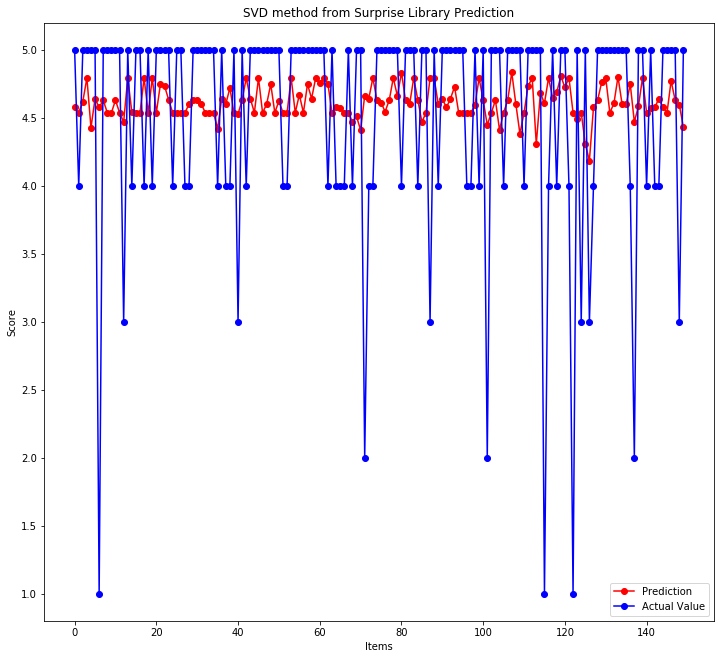

In [114]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_svd[:150], '-or', label='Prediction')
plt.plot(y_test_svd[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("SVD method from Surprise Library Prediction")

In [115]:
from sklearn.metrics import mean_squared_error
svd_rms = mean_squared_error(y_pred_svd, y_test_svd)

In [116]:
svd_rms

0.5386716758808845

In [117]:
df = df.replace('', np.nan, regex=True)

In [118]:
df['name'].isna().any()

False

In [119]:
df[df['name'] == ''].index

Int64Index([], dtype='int64')

In [120]:
df['brand'].isna().any()

True

In [121]:
df[df['brand'] == ''].index

Int64Index([], dtype='int64')

In [122]:
from sklearn_pandas import CategoricalImputer
imputerCategorical = CategoricalImputer()

In [123]:
df['brand'] = imputerCategorical.fit_transform(df['brand'])

In [124]:
df['brand'].isna().any()

False

In [125]:
df['categories'].isna().any()

True

In [126]:
df['categories'] = imputerCategorical.fit_transform(df['categories'])

In [127]:
df['categories'].isna().any()

False

In [128]:
df['manufacturer'].isna().any()

True

In [129]:
df['manufacturer'] = imputerCategorical.fit_transform(df['manufacturer'])

In [130]:
df['manufacturer'].isna().any()

False

In [131]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder = LabelEncoder()

In [132]:
frames = [df['name'], df['brand'], df['categories'], df['manufacturer']]

In [133]:
df_new = pd.concat(frames, axis=1)

In [134]:
X = df_new.iloc[:, :].values

In [135]:
X

array([['AllNew Fire HD 8 Tablet  8 HD Display  WiFi  16 GB  Includes Special Offers  Magenta',
        'Amazon',
        'Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets',
        'Amazon'],
       ['AllNew Fire HD 8 Tablet  8 HD Display  WiFi  16 GB  Includes Special Offers  Magenta',
        'Amazon',
        'Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets',
        'Amazon'],
       ['AllNew Fire HD 8 Tablet  8 HD Display  WiFi  16 GB  Includes Special Offers  Magenta',
        'Amazon',
        'Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets',
        'Amazon'],
       ...,
       ['Fire Tablet  7 Display  WiFi  8 GB  Includes Special Offers  Magenta',
        'Amazon',
        'Computers/Tablets & Networking,Tablet & eBook Reader Accs,Chargers & Sync Cables,Power Adapters & Cables,Kindle Store,Amazon Device Accessories,Fire Tablet Accessories,Kindle Fire (2nd Generation) Accessories'

In [136]:
for i in range(X.shape[1]):
    X[:, i] =  labelencoder.fit_transform(X[:, i]) 




In [137]:
X

array([[1, 0, 21, 0],
       [1, 0, 21, 0],
       [1, 0, 21, 0],
       ...,
       [39, 0, 8, 1],
       [39, 0, 8, 1],
       [0, 0, 25, 0]], dtype=object)

In [138]:
y = df['reviews.rating']

In [139]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

In [140]:
from sklearn.ensemble import RandomForestRegressor

In [141]:
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)

In [142]:
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [143]:
y_pred_random_forest = regr.predict(X_test).tolist()

In [144]:
y_test2 = []
for item in y_test:
    y_test2.append(item)
y_test = y_test2

Current size: [12.0, 11.0]


Text(0.5,1,'Random Forest Regressor')

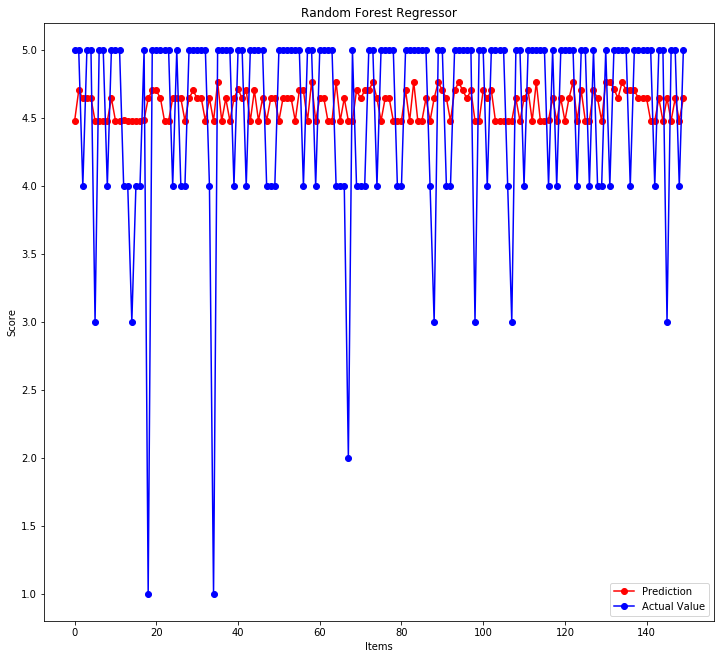

In [145]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_random_forest[:150], '-or', label='Prediction')
plt.plot(y_test[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Random Forest Regressor")

In [146]:

random_forest_rms = mean_squared_error(y_pred_random_forest, y_test)

In [147]:
random_forest_rms

0.5156770885259061

In [148]:
from sklearn.neighbors import KNeighborsClassifier

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train.astype('int')) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [150]:
y_pred_k_nearest = neigh.predict(X_test)

In [151]:
y_pred_k_nearest

array([5, 5, 5, ..., 5, 5, 5])

Current size: [12.0, 11.0]


Text(0.5,1,'K Nearest Neighbor')

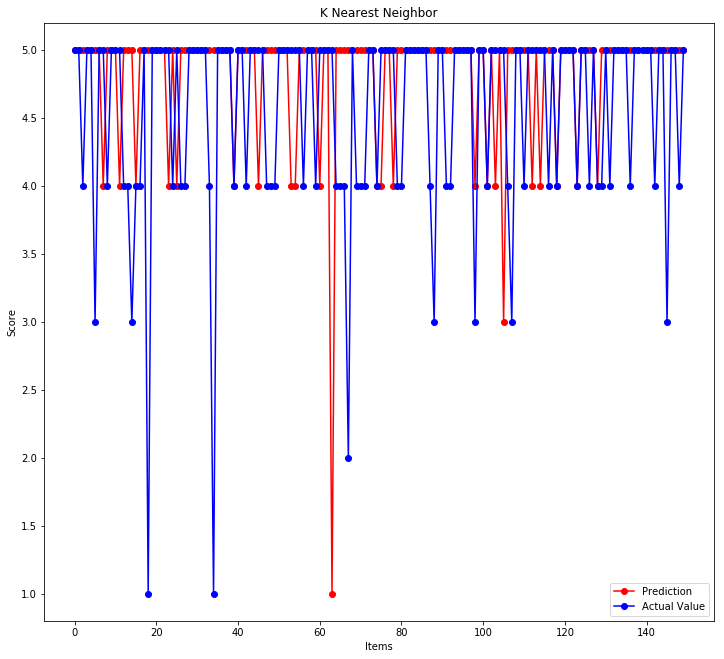

In [152]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_k_nearest[:150], '-or', label='Prediction')
plt.plot(y_test2[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("K Nearest Neighbor")

In [153]:
k_nearest_rms = mean_squared_error(y_pred_k_nearest, y_test)

In [154]:
k_nearest_rms

0.7788193061768416

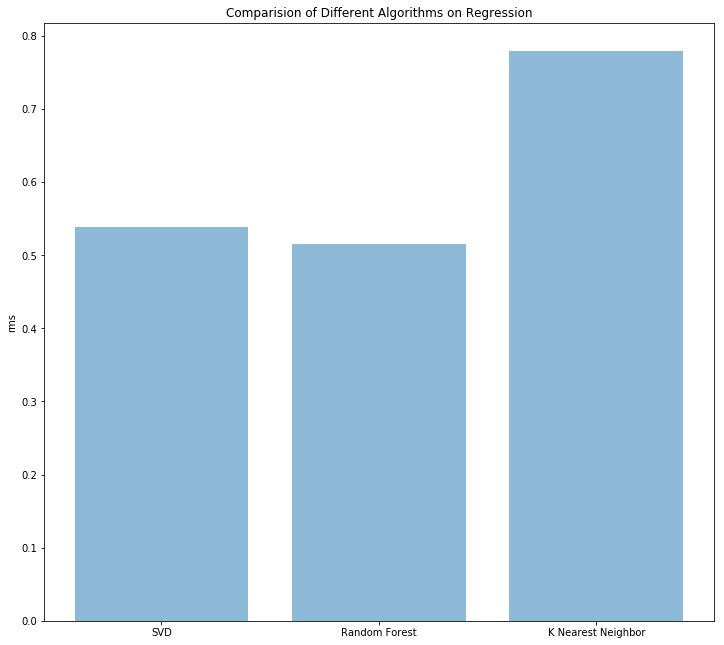

In [155]:
objects = ('SVD', 'Random Forest', 'K Nearest Neighbor')
y_pos = np.arange(len(objects))
performance = [svd_rms, random_forest_rms,  k_nearest_rms]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('rms')
plt.title('Comparision of Different Algorithms on Regression')
 
plt.show()